# Preprocess Data

In [1]:
import matplotlib
import pandas
import numpy

In [2]:
books = pandas.read_csv('archive/Books.csv')
ratings = pandas.read_csv('archive/Ratings.csv')

C:\Users\stanl\AppData\Local\Temp\ipykernel_1088\432722169.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pandas.read_csv('archive/Books.csv')


In [3]:
books = books.drop(columns=['Image-URL-S', 'Image-URL-M'])
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...


<Axes: xlabel='Year-Of-Publication'>

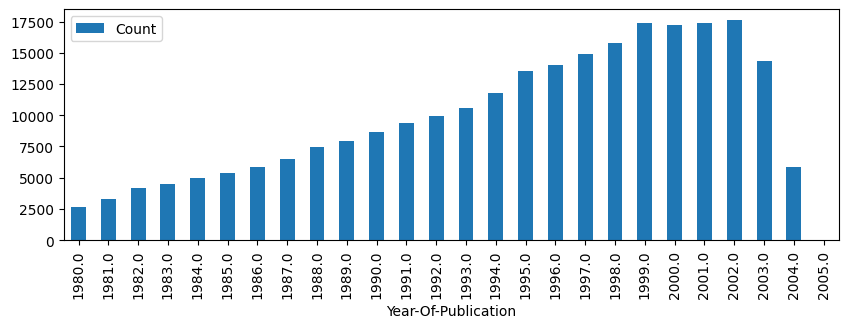

In [4]:
books['Year-Of-Publication'] = pandas.to_numeric(books['Year-Of-Publication'], errors='coerce')
books_year_count = books[(books['Year-Of-Publication'] > 1979) & (books['Year-Of-Publication'] < 2006)].groupby('Year-Of-Publication').count()
books_year_count = books_year_count.rename(columns={'ISBN': 'Count'})
books_year_count.plot.bar(y='Count', figsize=(10, 3))

<Axes: xlabel='Book-Author'>

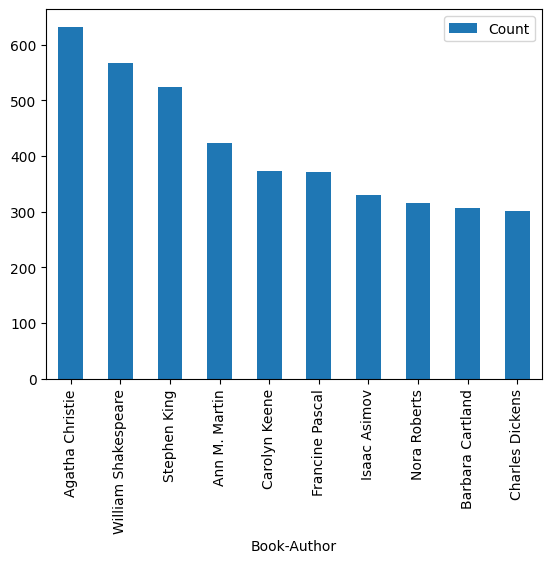

In [5]:
books_author_count = books.groupby('Book-Author').count()
books_author_count = books_author_count.rename(columns={'ISBN': 'Count'})
books_author_count = books_author_count.sort_values('Count', ascending=False)
books_author_count.head(10).plot.bar(y='Count')

<Axes: xlabel='Book-Rating'>

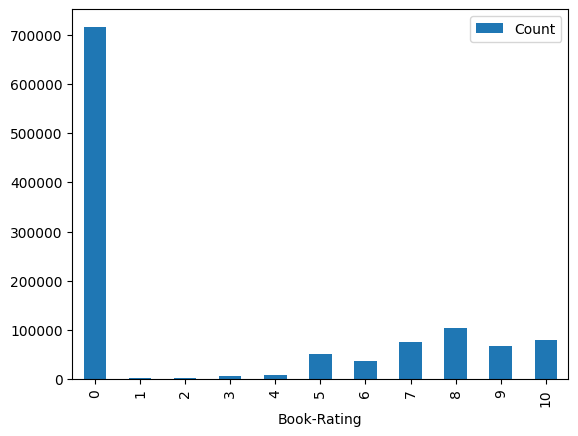

In [6]:
ratings_count = ratings.groupby('Book-Rating').count()
ratings_count = ratings_count.rename(columns={'User-ID': 'Count'})
ratings_count = ratings_count.drop(['ISBN'], axis=1)
ratings_count.plot.bar(y='Count')

In [7]:
ratings = ratings[ratings['ISBN'].isin(books['ISBN'])] # Some books aren't in the books database but are in ratings
ratings = ratings[ratings['Book-Rating'] != 0] # Remove implicit (zero) ratings
# ratings.to_pickle('ratings')
ratings.head()

,User-ID,ISBN,Book-Rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
8,276744,038550120X,7
16,276747,0060517794,9


In [8]:
user_ratings_count = ratings.groupby('User-ID').count()
print(user_ratings_count.describe())
user_ratings_count = user_ratings_count[user_ratings_count['ISBN'] >= 3] # Users with atleast than 5 ratings
user_ratings_count.shape

               ISBN   Book-Rating
count  68091.000000  68091.000000
mean       5.637191      5.637191
std       41.742511     41.742511
min        1.000000      1.000000
25%        1.000000      1.000000
50%        1.000000      1.000000
75%        3.000000      3.000000
max     6943.000000   6943.000000


(20194, 2)

<Axes: >

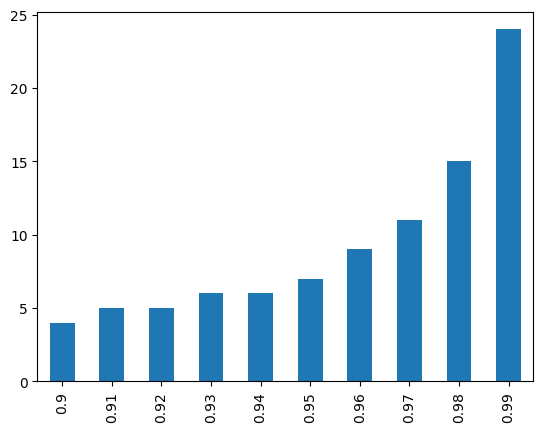

In [9]:
book_ratings_count = ratings.groupby('ISBN').count()
book_ratings_count = book_ratings_count.drop(columns=['User-ID'])
book_ratings_count = book_ratings_count.rename(columns={'Book-Rating': 'Rating-Count'})
book_ratings_count['Rating-Count'].quantile(numpy.round(numpy.arange(0.9, 1, 0.01), 2)).plot.bar() # Round for floating point error

In [10]:
books = books.merge(book_ratings_count, on='ISBN', how='left')
books['Rating-Count'] = books['Rating-Count'].fillna(0)

In [11]:
average_book_ratings = ratings.groupby('ISBN').mean().round(2)
average_book_ratings = average_book_ratings.drop(columns=['User-ID'])
average_book_ratings = average_book_ratings.rename(columns={'Book-Rating': 'Average-Book-Rating'})
books = books.merge(average_book_ratings, on='ISBN', how='left')
books['Average-Book-Rating'] = books['Average-Book-Rating'].fillna(0)
# books.to_pickle('books')

In [12]:
# ratings = ratings[ratings['User-ID'].isin(user_ratings_count.index)] # Remove users with less than 5 ratings, Perhaps this is not a good idea
book_ratings_count = book_ratings_count[book_ratings_count['Rating-Count'] >= 24] # Books with atleast than 24 rating
ratings = ratings[ratings['ISBN'].isin(book_ratings_count.index)]

# Replace 0 ratings with the average
# ratings = ratings[ratings['Book-Rating'] != 0]
# avg_ratings = ratings[non_zero_ratings].groupby('ISBN')['Book-Rating'].mean().round(0)
# ratings.loc[~non_zero_ratings, 'Book-Rating'] = ratings['ISBN'].map(avg_ratings)
# ratings['Book-Rating'] = 1
# ratings.head()

In [13]:
matrix = ratings.pivot(index='ISBN', columns='User-ID', values='Book-Rating').fillna(0)
# matrix.to_pickle('matrix')
matrix.shape

(1586, 28915)

# Find Nearest Neighbors

In [14]:
from sklearn.neighbors import NearestNeighbors
import joblib

model = NearestNeighbors(metric='cosine', n_neighbors=7)
model.fit(matrix)
# joblib.dump(model, 'model.pkl')

NearestNeighbors(metric='cosine', n_neighbors=7)

In [15]:
book = matrix[matrix.index == '0060256672'].values
book

array([[0., 0., 0., ..., 0., 0., 0.]])

In [16]:
neigh_dist, neigh_ind = model.kneighbors(book, return_distance=True)

In [17]:
neigh_dist

array([[0.        , 0.85732709, 0.87798088, 0.88087861, 0.88380854,
        0.89029957, 0.89804125]])

In [18]:
neigh_ind

array([[  21,   20,  111, 1315, 1323,  825,  470]], dtype=int64)

In [19]:
for i in neigh_ind[0]:
    print(books[books['ISBN'] == matrix.index[i]])

            ISBN                                    Book-Title  \
1101  0060256672  Where the Sidewalk Ends : Poems and Drawings   

           Book-Author  Year-Of-Publication      Publisher  \
1101  Shel Silverstein               1974.0  HarperCollins   

                                            Image-URL-L  Rating-Count  \
1101  http://images.amazon.com/images/P/0060256672.0...          25.0   

      Average-Book-Rating  
1101                  9.4  
             ISBN  Book-Title       Book-Author  Year-Of-Publication  \
16190  0060248025  Falling Up  Shel Silverstein               1996.0   

           Publisher                                        Image-URL-L  \
16190  HarperCollins  http://images.amazon.com/images/P/0060248025.0...   

       Rating-Count  Average-Book-Rating  
16190          30.0                 8.77  
            ISBN                                   Book-Title  Book-Author  \
1097  0140077022  White Noise (Contemporary American Fiction)  Don DeLillo   

